In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
import requests
import openmeteo_requests
import requests_cache
from retry_requests import retry
import plotly.express as px
import os
import sys
import toml
from pymongo import MongoClient
from pymongo.server_api import ServerApi
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from statsmodels.tsa.seasonal import STL
from sklearn.neighbors import LocalOutlierFactor
from scipy.fftpack import dct, idct
from scipy.signal import stft
import plotly.colors as pc

# Define custom colors from utils.py
sys.path.append(os.path.abspath(".."))
# Define custom colors
import helpers.utils
color_map = utils.get_color_map()
custom_colors = utils.custom_colors

# Find coordinates using Open Meteo´s 

In [ ]:
# Function to get latitude and longitude using Open-Meteo Geocoding API
def get_coordinates(city):
    url = "https://geocoding-api.open-meteo.com/v1/search"
    params = {"name": city, "count": 1, "language": "en", "format": "json"}
    response = requests.get(url, params=params)
    response.raise_for_status()
    data = response.json()
    result = data["results"][0]
    return result["latitude"], result["longitude"]

# Price areas and representative cities
price_areas = {
    "NO1": "Oslo",
    "NO2": "Kristiansand",
    "NO3": "Trondheim",
    "NO4": "Tromsø",
    "NO5": "Bergen"
}

# Create DataFrame with price area, city, latitude, and longitude
city_data = []
for code, city in price_areas.items():
    lat, lon = get_coordinates(city)
    city_data.append({
        "price_area": code,
        "city": city,
        "latitude": lat,
        "longitude": lon
    })

cities_df = pd.DataFrame(city_data)
cities_df


# Create function for the API download
I will use the code from [open meteo historical weather API](https://open-meteo.com/en/docs/historical-weather-api) to create the function

In [ ]:
# Set up an Open-Meteo API client with caching and retrying
cache_session = requests_cache.CachedSession('.cache', expire_after=-1)
retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
openmeteo = openmeteo_requests.Client(session=retry_session)


def download_era5_data(latitude, longitude, year):
    """
    Download ERA5 reanalysis data from the Open-Meteo API for a given location and year.

    Parameters
    ----------
    latitude : float
        Latitude of the location
    longitude : float
        Longitude of the location
    year : int
        Year of data to download (e.g. 2019)

    Returns
    -------
    pandas.DataFrame
        DataFrame containing hourly weather data for the specified location and year
    """

    # Define the time period
    start_date = f"{year}-01-01"
    end_date = f"{year}-12-31"

    # Define which weather variables to retrieve
    variables = [
        "temperature_2m",
        "precipitation",
        "wind_speed_10m",
        "wind_gusts_10m",
        "wind_direction_10m"
    ]

    # Set up the API parameters
    url = "https://archive-api.open-meteo.com/v1/archive"
    params = {
        "latitude": latitude,
        "longitude": longitude,
        "start_date": start_date,
        "end_date": end_date,
        "hourly": variables,
        "models": "era5"
    }

    # Request data from the API
    responses = openmeteo.weather_api(url, params=params)
    response = responses[0]  # Only one location requested

    # Extract hourly data (order must match the variable list)
    hourly = response.Hourly()
    hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
    hourly_precipitation = hourly.Variables(1).ValuesAsNumpy()
    hourly_wind_speed_10m = hourly.Variables(2).ValuesAsNumpy()
    hourly_wind_gusts_10m = hourly.Variables(3).ValuesAsNumpy()
    hourly_wind_direction_10m = hourly.Variables(4).ValuesAsNumpy()

    # Create hourly date range from timestamps
    hourly_data = {
        "time": pd.date_range(
            start=pd.to_datetime(hourly.Time(), unit="s", utc=True),
            end=pd.to_datetime(hourly.TimeEnd(), unit="s", utc=True),
            freq=pd.Timedelta(seconds=hourly.Interval()),
            inclusive="left"
        )
    }

    # Add data columns
    hourly_data["temperature_2m"] = hourly_temperature_2m
    hourly_data["precipitation"] = hourly_precipitation
    hourly_data["wind_speed_10m"] = hourly_wind_speed_10m
    hourly_data["wind_gusts_10m"] = hourly_wind_gusts_10m
    hourly_data["wind_direction_10m"] = hourly_wind_direction_10m

    # Convert to DataFrame
    df = pd.DataFrame(hourly_data)

    return df

# Apply function to Bergen in 2019

In [ ]:
# Get Bergen coordinates from the cities DataFrame
bergen = cities_df[cities_df["city"] == "Bergen"].iloc[0]

# Download ERA5 data for Bergen in 2019
bergen_2019 = download_era5_data(bergen["latitude"], bergen["longitude"], 2019)

# Show the first few rows
bergen_2019.head()

# Plot temperature

In [ ]:
# Plot temperature as a function of time
fig = px.line(
    bergen_2019,
    x="time",
    y="temperature_2m",
    title="Hourly Temperature in Bergen, 2019 (ERA5)",
    labels={
        "time": "Time",
        "temperature_2m": "Temperature (°C)"
    },
    color_discrete_sequence=custom_colors
)

# Clean layout adjustments
fig.update_layout(
    template="plotly_white",
    xaxis_title="Date",
    yaxis_title="Temperature (°C)",
    title_x=0.5,
    showlegend=False,
    margin=dict(l=40, r=40, t=60, b=40)
)

fig.show()

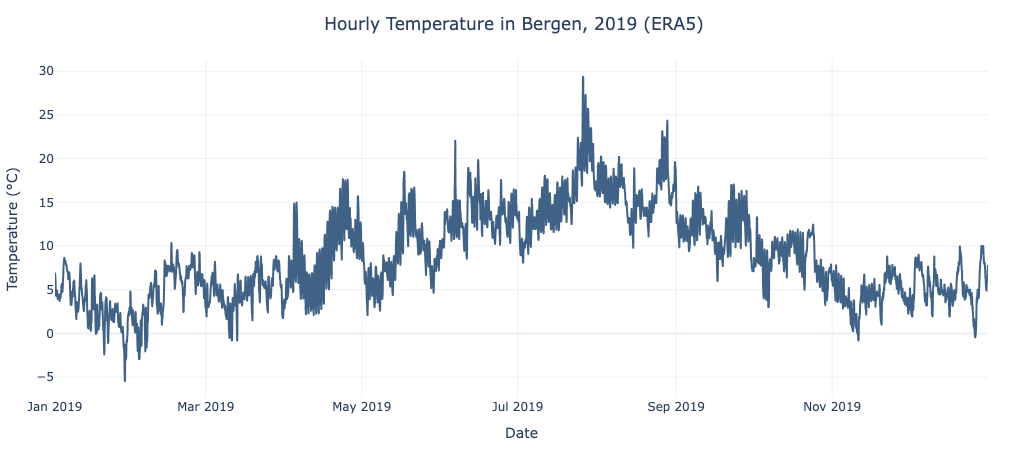

We can clearly see the expected seasonal pattern; colder temperatures during the winter months (January–March and November–December) and warmer conditions in the summer (June–August).

Temperatures fluctuate frequently, which reflects Bergen’s maritime climate, characterized by rapid weather changes and mild but variable conditions.

# High-pass filtering

In [ ]:
# Function to look at high-pass filtering using DCT
def high_pass_dct(series, keep_fraction=0.1):
    """
    High-pass filter using the Discrete Cosine Transform (DCT).
    Removes low-frequency (seasonal) components to highlight short-term variations.

    Parameters
    ----------
    series : array-like
        Input temperature series.
    keep_fraction : float, optional
        Fraction of high-frequency components to keep (default 0.1).

    Returns
    -------
    numpy.ndarray
        High-pass filtered temperature series (SATV).
    """
    x = np.asarray(series)
    X = dct(x, norm="ortho")

    # Remove low-frequency part
    n = len(X)
    cutoff = int(n * (1 - keep_fraction))
    X[:cutoff] = 0

    # Inverse DCT to reconstruct the filtered signal
    return idct(X, norm="ortho")

# Apply the filter to Bergen data
bergen_2019["SATV"] = high_pass_dct(bergen_2019["temperature_2m"], keep_fraction=0.01)
bergen_2019.head()

A new column "SATV" is added to the Bergen dataframe.

In [ ]:
# Plot histogram of SATV values
fig = px.histogram(
    x=bergen_2019["SATV"],
    nbins=50,
    title="Distribution of SATV (Bergen 2019)",
    labels={"x": "SATV (°C)"},
    color_discrete_sequence=[custom_colors[0]]
)
fig.update_layout(template="plotly_white", title_x=0.5)
fig.show()

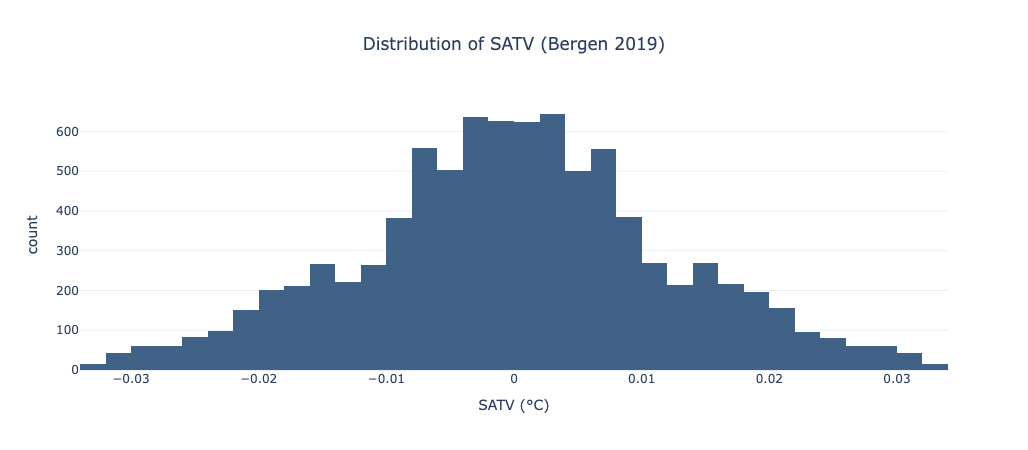

The histogram of SATV for Bergen (2019) shows a symmetric, bell-shaped distribution centered near zero. This indicates that the DCT filtering (keep_low_fraction = 0.01) successfully removed the slow seasonal trend, leaving short-term variations that are approximately normally distributed.

# Statistical Process Control

In [ ]:
# Function to plot temperature with SPC boundaries derived from SATV
def temperature_spc_from_satv(
    time, temperature,
    keep_low_fraction=0.01,    # how smooth the trend is (smaller -> smoother)
    k=3.0,                     # “±k” width for limits
    robust=True,               # median±k*MAD if True, else mean±k*std
    scale_mad=True             # multiply MAD by 1.4826 if you want SD-equivalent
    ):
    """
    Plot temperature with SPC boundaries derived from SATV (DCT high-pass).

    Parameters
    ----------
    time : array-like
        Time values (e.g. pandas datetime).
    temperature : array-like
        Temperature values.
    keep_low_fraction : float, optional
        Fraction of low-frequency DCT components to keep for trend (default 0.005).
    k : float, optional
        Width multiplier for SPC limits (default 3.0).
    robust : bool, optional
        Use median±k*MAD if True, else mean±k*std (default True).
    scale_mad : bool, optional
        Scale MAD by 1.4826 to estimate standard deviation (default False).
    
    Returns
    -------
    fig : plotly.graph_objects.Figure
        Plotly figure with temperature and SPC limits.
    summary : dict
        Summary statistics about outliers and limits.
    """

    t = np.asarray(time)
    x = np.asarray(temperature, dtype=float)

    # Low-pass trend via DCT (keep only the lowest frequencies)
    X = dct(x, norm="ortho")
    n = len(X)
    k_low = max(1, int(n * keep_low_fraction))
    X_lp = np.zeros_like(X)
    X_lp[:k_low] = X[:k_low]
    trend = idct(X_lp, norm="ortho")

    # High-pass component (SATV)
    satv = x - trend

    # Robust (or classical) whole-year limits in SATV space
    if robust:
        center = np.median(satv)
        mad = np.median(np.abs(satv - center))
        spread = (1.4826 * mad) if scale_mad else mad
    else:
        center = np.mean(satv)
        spread = np.std(satv)

    upper_satv = center + k * spread
    lower_satv = center - k * spread

    # Map limits to temperature space to get curves
    upper_curve = trend + upper_satv
    lower_curve = trend + lower_satv

    # Outliers determined in SATV space
    is_outlier = (satv > upper_satv) | (satv < lower_satv)

    # Build plot
    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=t[~is_outlier], y=x[~is_outlier],
        mode="lines", name="Temperature (Inliers)",
        line=dict(color=utils.custom_colors[0], width=1)
    ))
    fig.add_trace(go.Scatter(
        x=t[is_outlier], y=x[is_outlier],
        mode="markers", name="Outliers",
        marker=dict(color="#d62828", size=6, opacity=0.9)
    ))
    fig.add_trace(go.Scatter(
        x=t, y=upper_curve, mode="lines", name="Upper SPC limit",
        line=dict(color=utils.custom_colors[-1], dash="dash")
    ))
    fig.add_trace(go.Scatter(
        x=t, y=lower_curve, mode="lines", name="Lower SPC limit",
        line=dict(color=utils.custom_colors[-1], dash="dash")
    ))
    fig.update_layout(
        template="plotly_white",
        title="Temperature with SPC boundaries derived from SATV",
        xaxis_title="Date", yaxis_title="Temperature (°C)", title_x=0.5
    )

    summary = {
        "n_outliers": int(is_outlier.sum()),
        "n_total": int(n),
        "percent_outliers": round(100 * is_outlier.mean(), 2),
        "satv_center": float(center),
        "satv_spread": float(spread),
        "upper_satv_limit": float(upper_satv),
        "lower_satv_limit": float(lower_satv),
        "keep_low_fraction": keep_low_fraction,
        "k": k,
        "robust": robust,
        "scale_mad": scale_mad
    }
    return fig, summary

In [ ]:
time = bergen_2019["time"].to_numpy()
temp = bergen_2019["temperature_2m"].to_numpy()

fig, summary = temperature_spc_from_satv(time, temp)
fig.show()
print(summary)

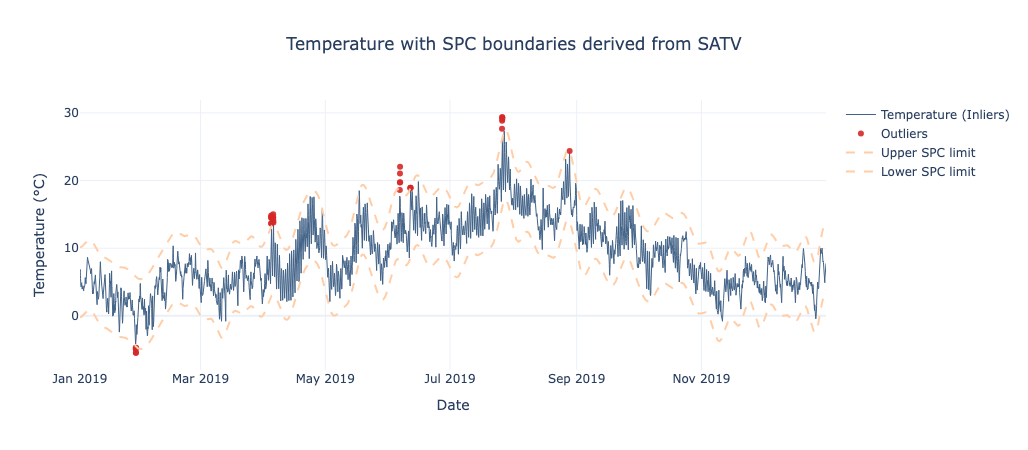

The SPC plot shows temperature with curved control limits derived from the SATV. Using robust statistics (median ± 3 × 1.4826 × MAD) gives 30 outliers, or 0.34 % of all observations, which closely matches the expected 3σ coverage for an approximately normal process. The detected outliers mainly occur during extreme summer highs and winter lows, confirming that the limits are both realistic and sensitive to true anomalies.

# Plot preciptation

In [ ]:
# function to plot precipitation with LOF anomalies
def precipitation_lof_plot(
    time, precipitation,
    contamination=0.01,
    n_neighbors=30
):
    """
    Plot precipitation over time with anomalies detected by Local Outlier Factor (LOF).

    Parameters
    ----------
    time : array-like
        Time values.
    precipitation : array-like
        Precipitation series (mm).
    contamination : float, optional
        Proportion of points to mark as outliers (default 0.01 = 1%).
    n_neighbors : int, optional
        Number of neighbors used by LOF (default 20).

    Returns
    -------
    fig : plotly.graph_objects.Figure
        Interactive plot of precipitation with outliers marked.
    summary : dict
        Summary statistics of outlier detection.
    """
    # Prepare data
    X = np.array(precipitation).reshape(-1, 1)

    # Fit Local Outlier Factor
    lof = LocalOutlierFactor(
        n_neighbors=n_neighbors,
        contamination=contamination
    )
    labels = lof.fit_predict(X)   # -1 = outlier, 1 = inlier
    scores = -lof.negative_outlier_factor_

    # Identify outliers
    is_outlier = labels == -1
    n_total = len(X)
    n_outliers = int(is_outlier.sum())
    percent_outliers = 100 * n_outliers / n_total

    # Plot
    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=np.array(time)[~is_outlier],
        y=X[~is_outlier, 0],
        mode="lines",
        name="Precipitation (Inliers)",
        line=dict(color=utils.custom_colors[0], width=1)
    ))
    fig.add_trace(go.Scatter(
        x=np.array(time)[is_outlier],
        y=X[is_outlier, 0],
        mode="markers",
        name="Outliers (LOF)",
        marker=dict(color="#d62828", size=6, opacity=0.8)
    ))

    fig.update_layout(
        template="plotly_white",
        title="Precipitation with Local Outlier Factor (LOF) Anomalies",
        xaxis_title="Date",
        yaxis_title="Precipitation (mm)",
        title_x=0.5
    )

    # Summary
    summary = {
        "n_total": n_total,
        "n_outliers": n_outliers,
        "percent_outliers": round(percent_outliers, 2),
        "contamination": contamination,
        "n_neighbors": n_neighbors
    }

    return fig, summary

In [ ]:
# Test the function
fig, summary = precipitation_lof_plot(
    time=bergen_2019["time"],
    precipitation=bergen_2019["precipitation"],
    contamination=0.01  # 1% outliers
)
fig.show()
print(summary)

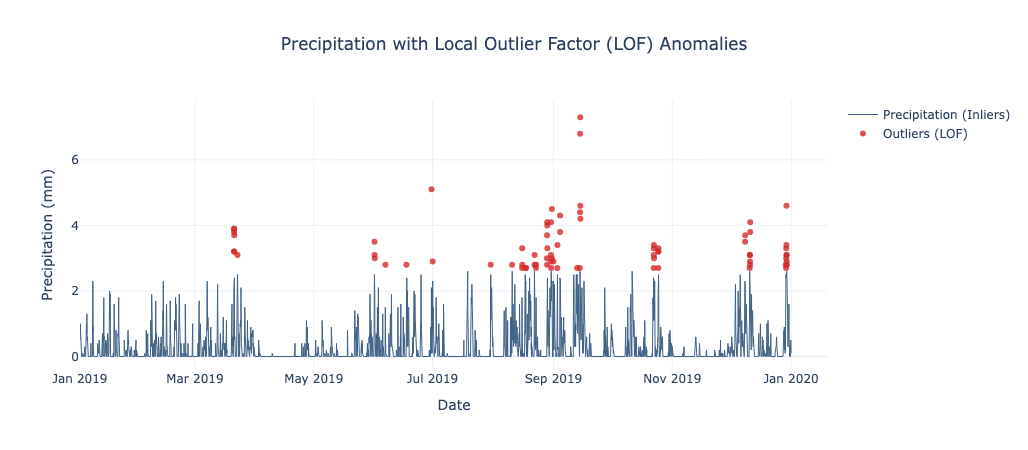

Because many hours have identical precipitation values (0 mm), the number of neighbors in the Local Outlier Factor method was increased from 20 to 30 to stabilize the density estimates. This adjustment removed the duplicate-value warning and produced 77 outliers (0.88 % of observations), consistent with the expected 1 % contamination level. The detected anomalies correspond to isolated, locally extreme rainfall events.

# Seasonal-Trend decomposition using LOESS

In [ ]:
def stl_decomposition_elhub(
    df,
    price_area="NO5",
    production_group="hydro",
    period=168,   
    seasonal=9,  
    trend=241,    
    robust=False
):
    """
    Perform STL decomposition (LOESS) on Elhub production data
    and return a Plotly figure with observed, trend, seasonal, and remainder.
    Color is automatically chosen based on the production group.

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame containing Elhub production data with columns:
        'starttime', 'pricearea', 'productiongroup', 'quantitykwh'.
    pricearea : str, optional
        Price area to filter data (default 'NO5').
    productiongroup : str, optional
        Production group to filter data (default 'hydro').
    period : int, optional
        Seasonal period for STL decomposition (default 168 for weekly seasonality in hourly data).
    seasonal : int, optional
        Seasonal smoothing parameter for STL (default 9).
    trend : int, optional
        Trend smoothing parameter for STL (must be odd, default 241).
    robust : bool, optional
        Whether to use robust fitting in STL (default False).   
        
    Returns
    ------- 
    fig : plotly.graph_objects.Figure
        Plotly figure with STL decomposition components.
    """

    # Retrieve project color palette
    color_map = utils.get_color_map()
    default_color = "#416287"
    line_color = color_map.get(production_group.lower(), default_color)

    # Case-insensitive filtering
    subset = df[
        (df["pricearea"].str.upper() == price_area.upper())
        & (df["productiongroup"].str.lower() == production_group.lower())
    ].copy()

    if subset.empty:
        raise ValueError(
            f"No data found for pricearea '{price_area}' and productiongroup '{production_group}'."
        )

    subset = subset.sort_values("starttime")
    subset["starttime"] = pd.to_datetime(subset["starttime"])

    # Perform STL decomposition
    stl = STL(
        subset["quantitykwh"],
        period=period,
        seasonal=seasonal,
        trend=trend,
        robust=robust
    )
    result = stl.fit()

    subset["trend"] = result.trend
    subset["seasonal"] = result.seasonal
    subset["remainder"] = result.resid

    # Build a standard STL-style Plotly figure (single color)
    fig = make_subplots(
        rows=4, cols=1, shared_xaxes=True,
        subplot_titles=("Observed", "Trend", "Seasonal", "Remainder"),
        vertical_spacing=0.04
    )

    components = ["quantitykwh", "trend", "seasonal", "remainder"]
    for i, comp in enumerate(components):
        fig.add_trace(
            go.Scatter(
                x=subset["starttime"],
                y=subset[comp],
                mode="lines",
                line=dict(color=line_color, width=1),
                name=comp.capitalize()
            ),
            row=i + 1, col=1
        )

    # Clean layout consistent with the course book
    fig.update_layout(
        height=950,
        template="plotly_white",
        title=f"STL Decomposition — {price_area.upper()} {production_group.capitalize()}",
        title_x=0.5,
        showlegend=False,
        margin=dict(t=80, b=50, l=50, r=20)
    )

    # Remove redundant y-axis titles
    for i in range(1, 5):
        fig["layout"][f"yaxis{i}"].title.text = ""

    # Add x-axis label only at the bottom
    fig.update_xaxes(title_text="Date", row=4, col=1)

    return fig

The chosen default parameters were selected based on both quantitative evaluation and visual inspection of the STL decomposition. Using period = 168 captures the clear weekly production cycle observed in the hourly data, while seasonal = 9 provides sufficient flexibility to model regular intra-week fluctuations without overfitting. A trend smoother of 241 produces a stable long-term component that still adapts to medium-scale variations in hydro production. The non-robust setting (robust=False) was preferred since the hydro data show few extreme outliers, allowing the decomposition to retain more real variation and achieve the lowest remainder variance among all tested configurations.

In [ ]:
# Load secrets
secrets = toml.load("/Users/teresemyhre/Documents/NMBU-iCloud/IND320/IND320-tereseivesdal/.streamlit/secrets.toml")
uri = secrets["MONGO"]["uri"]

# Create a new client and connect to the server
client = MongoClient(uri, server_api=ServerApi('1'))
# Send a ping to confirm a successful connection
try:
    client.admin.command('ping')
    print("Pinged your deployment. You successfully connected to MongoDB!")
except Exception as e:
    print(e)
db_name = secrets["MONGO"]["database"]
collection_name = secrets["MONGO"]["collection"]

db = client[db_name]
collection = db[collection_name]

cursor = collection.find(
    {},
    {"_id": 0, "pricearea": 1, "productiongroup": 1, "starttime": 1, "quantitykwh": 1}
)
df = pd.DataFrame(list(cursor))
df["starttime"] = pd.to_datetime(df["starttime"])
df.columns = [c.lower() for c in df.columns]
df.head()

## Test the function

In [ ]:
fig = stl_decomposition_elhub(df=df)
fig.show()

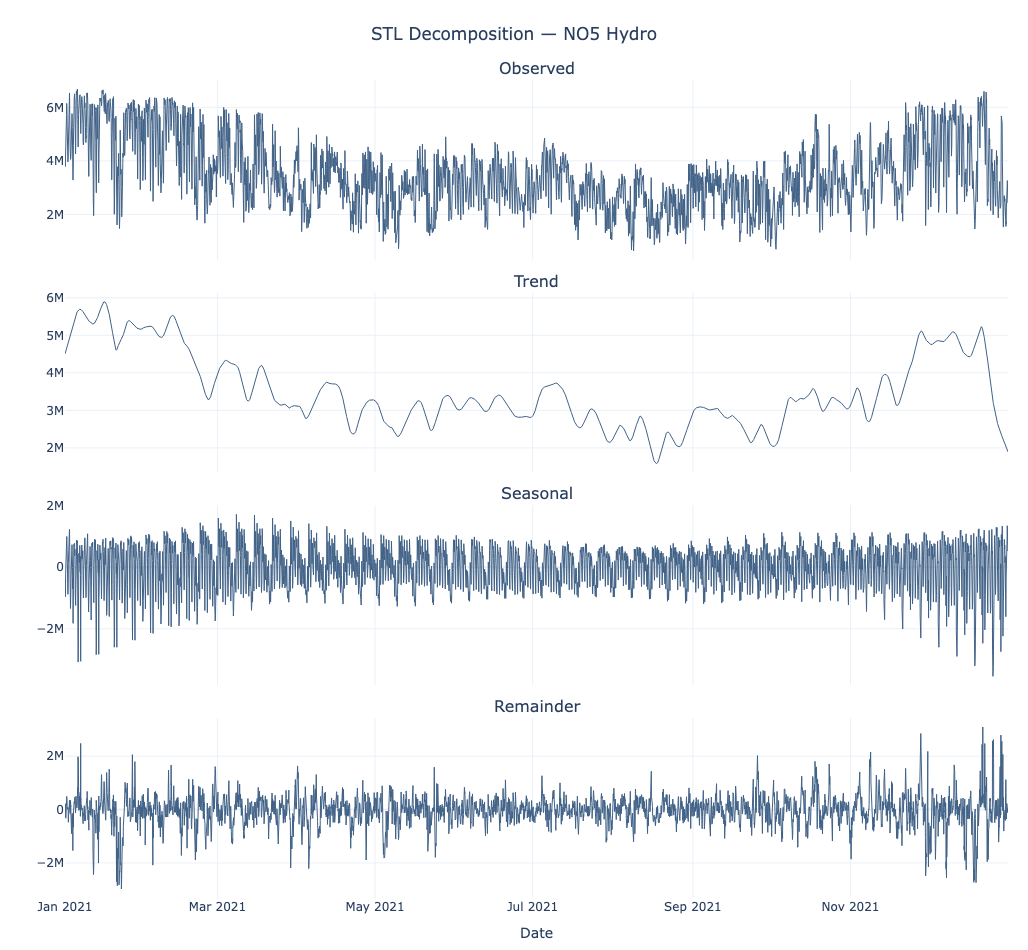

# Spectrogram

In [ ]:
def plot_spectrogram_elhub(data,
                           price_area = "NO5",
                           production_group= "hydro",
                           window_length = 24 * 7,  # one week
                           overlap = 24 * 4):      # 4 days overlap
    """
    Plot a Plotly STFT spectrogram for hourly Elhub production data.
    Each row in `data` must have: ['starttime','pricearea','productiongroup','quantitykwh'].
    
    Parameters
    ----------
    data : pandas.DataFrame
        DataFrame containing Elhub production data.
    price_area : str, optional
        Price area to filter data (default 'NO5').
    production_group : str, optional    
        Production group to filter data (default 'hydro'). 
    window_length : int, optional
        Length of each STFT window in samples (default one week = 24*7).
    overlap : int, optional
        Number of overlapping samples between windows (default ~3 days = 24*3).
    
    Returns
    -------
    fig : plotly.graph_objects.Figure
        Plotly figure containing the STFT spectrogram.
    """
    # Filter subset
    subset = data[
        (data["pricearea"].str.upper() == price_area.upper()) &
        (data["productiongroup"].str.lower() == production_group.lower())
    ].sort_values("starttime")

    if subset.empty:
        raise ValueError(f"No data for area={price_area}, group={production_group}")

    y = subset["quantitykwh"].to_numpy()

    # Short-Time Fourier Transform
    fs = 1.0  # one sample per hour --> frequencies in cycles/hour
    f, t, Zxx = stft(
        y,
        fs=fs,
        nperseg=window_length,
        noverlap=overlap,
        detrend="constant",     # chosen to remove mean from each segment
        boundary=None           # prevent padding with zeros
    )

    # Convert amplitude to dB scale for contrast 
    power_db = 10 * np.log10(np.abs(Zxx)**2 + 1e-12)
    
    # Define a custom color scale with more colors for smoothness
    custom_colors = ["#2A3F57", "#416287",  "#5890b7", "#9ecaec", "#ffcea8", "#ffb984", "#fd9e53"]

    # Interpolate the colors into a smoother gradient
    smooth_scale = pc.make_colorscale(custom_colors, scale=None)

    # Plotly heatmap
    fig = go.Figure(data=go.Heatmap(
        z=power_db,
        x=t / 24,       # convert hours to days on x-axis
        y=f * 24,       # convert cycles/hour → cycles/day
        colorscale=smooth_scale,
        colorbar=dict(title="Power [dB]"), 

    ))

    # Clean layout
    fig.update_layout(
        title=f"Spectrogram (STFT) — {price_area.upper()} {production_group.capitalize()}",
        template="plotly_white",
        xaxis_title="Time [days]",
        yaxis_title="Frequency [cycles/day]",
        width=950,
        height=520,
        title_x=0.5, 
    )

    return fig

I used a Short-Time Fourier Transform (STFT) to create a spectrogram of the hourly Elhub production data. The parameters were chosen to highlight meaningful temporal patterns while keeping the plot smooth and readable. A window length of 168 hours (one week) captures the weekly cycle in production, while an overlap of four days (96 hours) provides smoother transitions between windows. The sampling frequency was set to 1 sample per hour, and the frequency axis was scaled to cycles per day for easier interpretation of daily and weekly variations. The setting detrend="constant" removes the mean value in each window so that slow seasonal shifts do not dominate the spectrum. The boundary=None option ensures that only real data are used, without artificial padding at the edges.

In [ ]:
# Test the function
fig = plot_spectrogram_elhub(df, price_area="NO5", production_group="hydro")
fig.show()

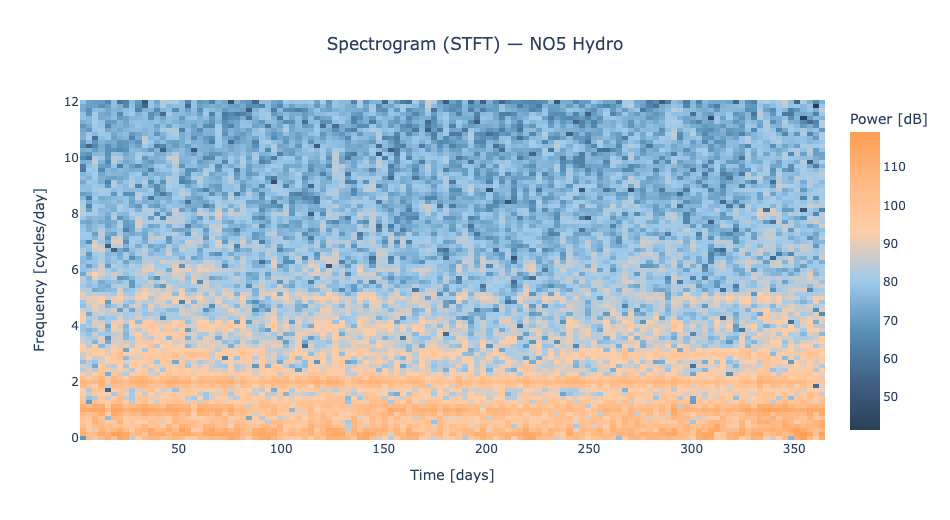

The resulting spectrogram shows that most of the energy is concentrated at low frequencies, reflecting slow, long-term variations in production. A clear band appears around one cycle per day, indicating a regular daily production pattern, while higher frequencies contain little power, meaning there is limited short-term fluctuation. Overall, the plot confirms that hydro production changes gradually with a strong daily rhythm and weak high-frequency noise.